# Alpaca Trading Workbook

### Create Class

In [46]:
# data & API packages
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, TimeFrameUnit
import sqlite3
import pandas as pd
import time
import random   
import ta
import numpy as np
from datetime import datetime, timedelta
#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf 

######################################################  Keras Wrapper Class (model build support) ######################################################
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    """
    this class is used as a keras wrapper so we can run ouur sequential models with various hyperparameters 
    """
    def __init__(self, model_type='LSTM', units=50, layers=2, dropout_rate=0.2, learning_rate=0.001, input_shape=(30, 12), epochs=10, batch_size=32):
        self.model_type = model_type
        self.units = units
        self.layers = layers
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def build_model(self):
        """
        Builds and compiles the Keras model based on the specified hyperparameters.
        """
        sequence_input = tf.keras.Input(shape=self.input_shape)
        x = sequence_input
        for _ in range(self.layers):
            if self.model_type == 'LSTM':
                x = tf.keras.layers.LSTM(self.units, return_sequences=True if _ < self.layers - 1 else False)(x)
            elif self.model_type == 'RNN':
                x = tf.keras.layers.SimpleRNN(self.units, return_sequences=True if _ < self.layers - 1 else False)(x)
            elif self.model_type == 'CNN':
                x = tf.keras.layers.Conv1D(filters=self.units, kernel_size=3, activation='relu')(x)
                x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
            x = tf.keras.layers.Dropout(self.dropout_rate)(x)

        x = tf.keras.layers.Flatten()(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        model = tf.keras.models.Model(inputs=sequence_input, outputs=outputs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Trains the model using the provided training data.
        """
        self.model = self.build_model()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Ensure validation data is passed for early stopping
        validation_data = (X_val, y_val) if X_val is not None and y_val is not None else None

        if validation_data:
            print(f"Validation data is available. X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
        else:
            print("No validation data provided.")
        
        self.model.fit(X, y, validation_data=validation_data, epochs=self.epochs, batch_size=self.batch_size, callbacks=[early_stopping], verbose=3)
        return self

    def predict(self, X):
        """
        Generates class predictions for the input samples.
        """
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        """
        Generates probability estimates for the input samples.
        """
        return self.model.predict(X)

    def score(self, X, y):
        """
        Calculates the F1 score of the model on the given test data and labels.
        """
        y_pred = self.predict(X)
        return f1_score(y, y_pred, average='weighted')

######################################################  The meat ######################################################
class AlpacaTradingBot:
    """
    This class is used to scrape stock data from the Alpaca API, store it locally in a SQLite Database, add indicators & perform predective analytics.
    """
    def __init__(self, keys_file_path='alpaca_keys.txt', base_url='https://paper-api.alpaca.markets', database_path=r'D:\Scripts\alpaca\alpaca_algo_trading\alpaca_data.db'):
        with open(keys_file_path, 'r') as file:
            self.api_key = file.readline().strip()
            self.api_secret = file.readline().strip()
        self.base_url = base_url
        self.api = tradeapi.REST(self.api_key, self.api_secret, base_url=base_url)
        self.api_call_count = 0
        self.database_path = database_path 
        # Define model types & provide dicationary of parameters
        self.model_categories = {
        'sequential': ['LSTM', 'RNN', 'CNN'],
        'classification': ['K-Nearest Neighbors', 'XGBoost', 'Logistic Regression', 'Random Forest', 'Neural Network', 'Gradient Boosting', 'Support Vector Machine']
        }
        self.models = {
            "K-Nearest Neighbors": (KNeighborsClassifier(), {
                'n_neighbors': [3, 5, 7, 9, 11, 13],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }),
            "XGBoost": (XGBClassifier(eval_metric='mlogloss'), {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 6, 9],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'reg_alpha': [0, 0.1, 1],
                'reg_lambda': [1, 1.5, 2]
            }),
            "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), {
                'penalty': ['l1', 'l2'],
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'saga'],
                'class_weight': ['balanced', None]
            }),
            "Random Forest": (RandomForestClassifier(), {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False],
                'class_weight': ['balanced', 'balanced_subsample', None]
            }),
            "Neural Network": (MLPClassifier(max_iter=1000, random_state=42), {
                'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (100, 100)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['adam', 'sgd', 'lbfgs'],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'learning_rate': ['constant', 'adaptive'],
                'learning_rate_init': [0.001, 0.01, 0.1]
            }),
            "Gradient Boosting": (GradientBoostingClassifier(), {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5, 6],
                'subsample': [0.7, 0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }),
            "Support Vector Machine": (SVC(), {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'class_weight': ['balanced', None]
            }),
            "Sequential Model Parameters": {
                'units': [32, 64, 128, 156],
                'learning_rate': [0.001, 0.01, 0.1],
                'batch_size': [32, 64, 128],
                'epochs': [10, 30, 50]
            }
        }

##### API Scraping methods

    def download_bar_data(self, stock, timeframe, start_date, end_date, pause=True):
        """
        This method is used to scrape bar data from the Alpaca API. 
        """
        all_data = []

        current_date = start_date
        while current_date <= end_date:
            # Check if it's a weekend (Saturday or Sunday) & skip, if so
            # if  datetime.strptime(current_date, "%Y-%m-%d").weekday() >= 5:
            #     current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
            #     continue

            # Split the day into two segments: midnight to noon, and noon to end of day because the API can only return 1,000 data points a day
            segments = [
                (f"{current_date}T00:00:00Z", f"{current_date}T11:59:59Z"),
                (f"{current_date}T12:00:00Z", f"{current_date}T23:59:59Z")
            ]

            for start_time, end_time in segments:
                try:
                    # Get data for the current day segment
                    bars = self.api.get_bars(stock, timeframe, start=start_time, end=end_time, limit=1000).df
                    self.api_call_count += 1  # Increment the API call counter
                    if not bars.empty:
                        bars['symbol'] = stock  # Add the stock symbol column
                        all_data.append(bars)
                        print(f"Data scraped for {current_date} through {end_time.split('T')[1]}...")
                    else:
                        print(f"No data available for segment: {current_date}: {start_time.split('T')[1]} - {end_time.split('T')[1]}")
                except tradeapi.rest.APIError as e:
                    print(f"API Error: {e}")
                    pause_duration = random.uniform(120, 240)  # Longer pause if an API error occurs
                    time.sleep(pause_duration)
                    continue
                
            # Random pause after each scrape.. API rate limits need to be considered when populating historic data to the database.
            if pause and (datetime.strptime(current_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days % 4 == 0:
                print(f"Total API calls made so far: {self.api_call_count}")
                pause_duration = random.uniform(10, 30)
                print(f"Pausing for {pause_duration} after scraping data for {current_date}...")
                print(f"__________________________________")
                time.sleep(pause_duration)

            # Move to the next day
            current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

        if all_data:
            combined_data = pd.concat(all_data)
            combined_data = combined_data.reset_index()  # Ensure the index is reset to have 'timestamp' as a column
            print("Scraping Bar Data complete for timerange:", combined_data['timestamp'].min(), " - ", combined_data['timestamp'].max())
            return combined_data[['symbol'] + [col for col in combined_data.columns if col not in ['symbol']]]
        else:
            return pd.DataFrame()

##### Model Preperation Methods

    def fetch_data(self, input_table, symbol):
        """
        This method grabs stock data from the stage table for model preperation
        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)
        try:
            input_data = pd.read_sql(f"SELECT distinct * FROM {input_table} WHERE SYMBOL = '{symbol}'", conn)
            if input_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")
            else:
                print(f"Data fetched for {symbol} from table {input_table}.")
            return input_data
        finally:
            conn.close()

    def preprocess_data(self, input_data):
        """
        This method gets our timestamps in EST
        """
        input_data['timestamp_utc'] = pd.to_datetime(input_data['TIMESTAMP'], utc=True)
        input_data['timestamp_est'] = input_data['timestamp_utc'].dt.tz_convert('US/Eastern')
        input_data['trading_hours_ind'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('09:30', '%H:%M').time()) & \
                                          (input_data['timestamp_est'].dt.time <= datetime.strptime('16:00', '%H:%M').time())
        input_data['trading_hours_ind_ext'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('10:30', '%H:%M').time()) & \
                                              (input_data['timestamp_est'].dt.time <= datetime.strptime('15:00', '%H:%M').time())
        input_data['date'] = input_data['timestamp_est'].dt.date
        input_data.sort_values(by='timestamp_est', inplace=True) 
        print(f"Timestamps converted to EST and sorted.")
        return input_data
    
    def calculate_indicators(self, input_data):
        """
        This method creates a bunch of technical indicators we will use for classification modeling
        """
        input_data['sma_15'] = ta.trend.sma_indicator(input_data['CLOSE'], window=15)
        input_data['sma_30'] = ta.trend.sma_indicator(input_data['CLOSE'], window=30)
        input_data['sma_120'] = ta.trend.sma_indicator(input_data['CLOSE'], window=120)
        input_data['ema_15'] = ta.trend.ema_indicator(input_data['CLOSE'], window=15)
        input_data['ema_30'] = ta.trend.ema_indicator(input_data['CLOSE'], window=30)
        input_data['ema_120'] = ta.trend.ema_indicator(input_data['CLOSE'], window=120)
        input_data['sma_15_120_pct_diff'] = ((input_data['sma_15'] - input_data['sma_120']) / input_data['sma_120']) * 100
        input_data['ema_15_120_pct_diff'] = ((input_data['ema_15'] - input_data['ema_120']) / input_data['ema_120']) * 100
        input_data['macd'] = ta.trend.macd(input_data['CLOSE'], window_slow=26, window_fast=12)
        input_data['macd_signal'] = ta.trend.macd_signal(input_data['CLOSE'], window_slow=26, window_fast=12, window_sign=9)
        input_data['macd_diff'] = input_data['macd'] - input_data['macd_signal']
        input_data['adx'] = ta.trend.adx(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14)
        input_data['rsi'] = ta.momentum.rsi(input_data['CLOSE'], window=14)
        input_data['stochastic_k'] = ta.momentum.stoch(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14, smooth_window=3)
        input_data['stochastic_d'] = ta.momentum.stoch_signal(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14, smooth_window=3)
        input_data['cci'] = ta.trend.cci(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=20)
        input_data['williams_r'] = ta.momentum.williams_r(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], lbp=14)
        bb_indicator = ta.volatility.BollingerBands(input_data['CLOSE'], window=20, window_dev=2)
        input_data['bollinger_hband'] = bb_indicator.bollinger_hband()
        input_data['bollinger_lband'] = bb_indicator.bollinger_lband()
        input_data['bollinger_mband'] = bb_indicator.bollinger_mavg()
        input_data['bollinger_width_percent'] = (input_data['bollinger_hband'] - input_data['bollinger_lband']) / input_data['CLOSE']
        input_data['bollinger_position'] = bb_indicator.bollinger_pband()
        input_data['atr'] = ta.volatility.average_true_range(input_data['HIGH'], input_data['LOW'], input_data['CLOSE'], window=14)
        input_data['obv'] = ta.volume.on_balance_volume(input_data['CLOSE'], input_data['VOLUME'])
        input_data['vwap'] = input_data.groupby(input_data['timestamp_est'].dt.date).apply(
            lambda x: (x['CLOSE'] * x['VOLUME']).cumsum() / x['VOLUME'].cumsum()
        ).reset_index(level=0, drop=True)
        input_data['ichimoku_tenkan_sen'] = ta.trend.ichimoku_conversion_line(input_data['HIGH'], input_data['LOW'], window1=9, window2=26)
        input_data['ichimoku_senkou_span_a'] = ta.trend.ichimoku_a(input_data['HIGH'], input_data['LOW'])
        input_data['ichimoku_senkou_span_b'] = ta.trend.ichimoku_b(input_data['HIGH'], input_data['LOW'])
        input_data['rvi'] = ta.trend.stc(input_data['CLOSE'])
        input_data['force_index'] = ta.volume.force_index(input_data['CLOSE'], input_data['VOLUME'])
        ao_indicator = ta.momentum.AwesomeOscillatorIndicator(input_data['HIGH'], input_data['LOW'])
        input_data['ao_ind'] = ao_indicator.awesome_oscillator()

        # Lagged Features
        lagged_features = []
        for lag in [1, 2, 3, 4, 5, 10, 20, 30]:
            lagged_features.append(input_data['rsi'].shift(lag))
            lagged_features.append(input_data['macd_diff'].shift(lag))
            lagged_features.append(input_data['cci'].shift(lag))
            lagged_features.append(input_data['adx'].shift(lag))
            lagged_features.append(input_data['CLOSE'].shift(lag))
            lagged_features.append(input_data['VOLUME'].shift(lag))
            lagged_features.append(input_data['vwap'].shift(lag))
            lagged_features.append(input_data['atr'].shift(lag))
        lagged_features_df = pd.concat(lagged_features, axis=1)
        lagged_feature_columns = [f'{col}_lag{lag}' for lag in [1, 2, 3, 4, 5, 10, 20, 30] for col in ['rsi', 'macd_diff', 'cci', 'adx', 'CLOSE', 'VOLUME', 'vwap', 'atr']]
        lagged_features_df.columns = lagged_feature_columns
        input_data = pd.concat([input_data, lagged_features_df], axis=1)

        # Polynomial Features
        squared_columns = pd.concat([
            input_data['rsi'] ** 2,
            input_data['macd_diff'] ** 2,
            input_data['cci'] ** 2,
            input_data['adx'] ** 2,
            input_data['bollinger_width_percent'] ** 2,
            input_data['stochastic_k'] ** 2,
            input_data['stochastic_d'] ** 2,
            input_data['williams_r'] ** 2,
            input_data['obv'] ** 2,
        ], axis=1)
        squared_columns.columns = [f'{col}_squared' for col in squared_columns.columns]
        input_data = pd.concat([input_data, squared_columns], axis=1)

        # Crossed indicators
        input_data['SMA_30_RSI'] = input_data['sma_30'] * input_data['rsi']
        input_data['MACD_STOCHASTIC_K'] = input_data['macd'] * input_data['stochastic_k']
        input_data['EMA_30_ATR'] = input_data['ema_30'] * input_data['atr']
        input_data['RSI_MACD_DIFF_INTERACTION'] = input_data['rsi'] * input_data['macd_diff']
        input_data['SMA_30_ADX_INTERACTION'] = input_data['sma_30'] * input_data['adx']
        input_data['BOLLINGER_POSITION_ATR_INTERACTION'] = input_data['bollinger_position'] * input_data['atr']
        input_data['HIGH_LOW_RANGE'] = input_data['HIGH'] - input_data['LOW']

        # Time-based features
        input_data['DAY_OF_WEEK'] = input_data['timestamp_est'].dt.dayofweek
        input_data['HOUR_OF_DAY'] = input_data['timestamp_est'].dt.hour
        input_data['TIME_OF_DAY'] = input_data['timestamp_est'].dt.time

        # Price-based features
        input_data['DAILY_MOVEMENT_SINCE_OPEN'] = input_data['CLOSE'] - input_data.groupby(input_data['timestamp_est'].dt.date)['CLOSE'].transform('first')
        input_data['WEEKLY_MOVEMENT_SINCE_OPEN'] = input_data['CLOSE'] - input_data.groupby(pd.Grouper(key='timestamp_est', freq='W'))['CLOSE'].transform('first')

        # Percentage movement features
        input_data['PCT_MOVEMENT_20_PERIODS'] = input_data['CLOSE'].pct_change(periods=20) * 100
        input_data['PCT_MOVEMENT_60_PERIODS'] = input_data['CLOSE'].pct_change(periods=60) * 100

        print(f"Technical indicators created.")
        return input_data

    def structure_dataframe(self, data, table_name):
        """
        This matches our columns to the database to make sure everything inserts correctly
        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)
        try:
            cursor = conn.execute(f"PRAGMA table_info({table_name})")
            table_columns = [row[1].upper() for row in cursor.fetchall()]

            # Match DataFrame columns to table columns (case insensitive)
            data_columns_upper = {col.upper(): col for col in data.columns}
            matched_columns = [data_columns_upper[col] for col in table_columns if col in data_columns_upper]

            # Identify dropped columns
            dropped_columns = set(data.columns) - set(matched_columns)
            print(f"Dropped columns: {dropped_columns}")

            # Reorder and drop columns
            reordered_data = data[matched_columns]
            print(f"Dataframe columns reordered to match {table_name}.")
            return reordered_data
        finally:
            conn.close()

    def save_dataframe(self, output_data, output_table):
        """
        This writes our table to the database.. truncates any existing data first
        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)
        try:
            # Truncate existing table
            self.db_write(f"DELETE FROM {output_table}")
            print(f"Truncated table {output_table}.")

            # Insert into table
            self.db_append(output_table, output_data)
            print(f"Prepared model data stored in {output_table}. Number of rows inserted: {len(output_data)}.")

        finally:
            conn.close()

    def modeling_prepare(self, input_table, output_table, symbol):
        """
        This method cleans the scraped raw stage data, adds indicator calculations on it inserts the otuput into a fresh table for classification modeling..
        """
        print(f"Preparing {symbol} data for classification modeling.")
        input_data = self.fetch_data(input_table, symbol)
        preprocessed_data = self.preprocess_data(input_data)
        indicators_data = self.calculate_indicators(preprocessed_data)
        reordered_data = self.structure_dataframe(indicators_data, output_table)
        self.save_dataframe(reordered_data, output_table)
        print(f"__________________________________")

##### Model Building Methods

    def prepare_data_for_modeling(self, database_path, symbol, table_name, start_date):
        """
        This method grabs the prepared modeling data from our database and orders it
        """
        conn = sqlite3.connect(database_path)
        df = pd.read_sql(f"SELECT * FROM {table_name} WHERE SYMBOL = '{symbol}' AND DATE >= '{start_date}'", conn)
        conn.close()
        print(f"Dataset generated from {table_name} table.")
        df.sort_values('TIMESTAMP_EST', inplace=True)
        print(f"Data sorted by timestamp.")
        return df

    def split_data_by_dates(self, df):
        """
        This method splits our data into training & validation by breaking out dates
        """
        unique_dates = df['DATE'].unique()
        train_dates, val_dates = train_test_split(unique_dates, test_size=0.2, random_state=42)
        print(f"Random sets of dates generated to split training & validation.")
        train_data = df[df['DATE'].isin(train_dates)].copy()
        val_data = df[df['DATE'].isin(val_dates)].copy()
        print(f"Data split into training & validation. Train data shape: {train_data.shape}, Validation data shape: {val_data.shape}")
        return train_data, val_data
    
    def create_targets(self, input_data, threshold=0.001):
        """
        This method creates our target variable. We want to see which direction the stock is going to break first.
        """
        input_data['TARGET_MOVEMENT_DIRECTION'] = np.nan

        for i in range(len(input_data)):
            for j in range(i + 1, len(input_data)):
                price_diff = input_data['CLOSE'].iloc[j] - input_data['CLOSE'].iloc[i]
                price_change_pct = price_diff / input_data['CLOSE'].iloc[i]

                if price_change_pct >= threshold:
                    input_data.at[i, 'TARGET_MOVEMENT_DIRECTION'] = 1  # Up
                    break
                elif price_change_pct <= -threshold:
                    input_data.at[i, 'TARGET_MOVEMENT_DIRECTION'] = 0  # Down
                    break

        input_data.dropna(subset=['TARGET_MOVEMENT_DIRECTION'], inplace=True)
        input_data['TARGET_MOVEMENT_DIRECTION'] = input_data['TARGET_MOVEMENT_DIRECTION'].astype(int)
        print(f"Targets created at target thershold of: {threshold}.")
        return input_data
    
    def create_sequences(self, df, feature_columns, target_column, sequence_length):
        """
        This method creates our sequences for our sequential modeling approaches
        """
        sequences = []
        targets = []
        trading_hours = []
        for i in range(len(df) - sequence_length):
            seq_features = df[feature_columns].iloc[i:i+sequence_length].values
            seq_target = df[target_column].iloc[i + sequence_length]
            seq_trading_hours = df['TRADING_HOURS_IND_EXT'].iloc[i + sequence_length]  # The trading hours indicator for the target row
            sequences.append(seq_features)
            targets.append(seq_target)
            trading_hours.append(seq_trading_hours)
        return np.array(sequences), np.array(targets), np.array(trading_hours)

    def smote_data(self, X_train, y_train, model_type=None):
        """
        Apply SMOTE to the training data.
        Sequential/classification models have different input datashapes
        """
        sm = SMOTE(random_state=42)
        
        if model_type == 'sequential':
            # Reshape for SMOTE, then reshape back for sequential models
            X_train_smoted, y_train_smoted = sm.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
            X_train_smoted = X_train_smoted.reshape(X_train_smoted.shape[0], *X_train.shape[1:])
        else:
            # Directly apply SMOTE for classification models
            X_train_smoted, y_train_smoted = sm.fit_resample(X_train, y_train)
        
        print(f"Data smoted.")
        return X_train_smoted, y_train_smoted

    def normalize_data(self, X_train, X_val, model_type=None):
        """
        Normalize data
        """
        scaler = StandardScaler()
        
        if model_type == 'sequential':
            # Reshape for normalization, then reshape back for sequential models
            X_train_normalized = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_val_normalized = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        else:
            # Directly normalize classification models
            X_train_normalized = scaler.fit_transform(X_train)
            X_val_normalized = scaler.transform(X_val)
        
        print(f"Data normalized.")
        return X_train_normalized, X_val_normalized

    def run_model_grid_search(self, model_type, X_train, y_train, X_val, y_val, symbol, features, n_iter, cv):
        """
        This method runs grid search & evaluates the outcome of various hyperparameters for both sequential and traditional classification models.
        """
        if model_type in self.model_categories['sequential']:
            param_grid = self.models["Sequential Model Parameters"]
            param_grid['model_type'] = [model_type]
            param_grid['input_shape'] = [X_train.shape[1:]]
            best_score = 0
            best_params = None
            best_model = None
            cv_splitter = TimeSeriesSplit(n_splits=cv)

            # Generate all possible combinations of parameters
            all_combinations = [(u, lr, bs, e) for u in param_grid['units'] for lr in param_grid['learning_rate'] for bs in param_grid['batch_size'] for e in param_grid['epochs']]
            # Randomly select n_iter combinations
            selected_combinations = random.sample(all_combinations, min(len(all_combinations), n_iter))

            # Iterate over randomly selected combinations of parameters for sequential models
            for units, learning_rate, batch_size, epochs in selected_combinations:
                scores = []  # List to store scores for each split
                for train_index, val_index in cv_splitter.split(X_train):
                    # Split the data according to TimeSeriesSplit
                    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
                    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

                    print(f"Testing model with units={units}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
                    model = KerasModelWrapper(units=units, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs, input_shape=X_train_cv.shape[1:])
                    model.fit(X_train_cv, y_train_cv, X_val_cv, y_val_cv)  # Fit model on the current split
                    score = model.score(X_val_cv, y_val_cv)  # Evaluate model on the current validation split
                    scores.append(score)  # Store score

                average_score = sum(scores) / len(scores)  # Calculate average score across all splits
                print(f"Average Score: {average_score}")

                # Update best model if current model is better based on average score
                if average_score > best_score:
                    best_score = average_score
                    best_params = {'units': units, 'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs}
                    best_model = model

            print(f"Best Score: {best_score}")
            print(f"Best Params: {best_params}")
            self.evaluate_model(best_model, model_type, X_val, y_val, symbol, features)
            print(f"Completed training for {model_type} model\n")
            print(f"__________________________________")

        else:
            # For classification models, the model is selected from a predefined dictionary of models and their parameter grids
            model, param_grid = self.models[model_type]
            grid_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                n_jobs=12,
                scoring='f1_weighted',
                random_state=42,
                verbose=3
            )
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            self.evaluate_model(best_model, model_type, X_val, y_val, symbol, features)
            print(f"Completed training for {model_type} model\n")
            print(f"__________________________________")

    def modeling_build(self, model_types, table_name, features, symbol, target_threshold, sequence_window, n_iter=20, cv=3, start_date='2020-01-01'):
        """
        This method executes our models
        """
        # Do minor data cleaning & create our target variables
        df = self.prepare_data_for_modeling(self.database_path, symbol, table_name, start_date)
        df = self.create_targets(df, target_threshold)
        
        # Define model types as sequential or classification based on class dictionary
        sequential_model_types = self.model_categories['sequential']
        classification_model_types = self.model_categories['classification']

        # Separate model types into sequential and classification
        sequential_models = [m for m in model_types if m in sequential_model_types]
        classification_models = [m for m in model_types if m in classification_model_types]

        # If we have any sequential models, prepare for modeling by creating sequences, filtering, smoting, and normalizing
        if sequential_models:
            train_data, val_data = self.split_data_by_dates(df)
            X_train, y_train, train_targets = self.create_sequences(train_data, features, 'TARGET_MOVEMENT_DIRECTION', sequence_window)
            X_val, y_val, val_targets = self.create_sequences(val_data, features, 'TARGET_MOVEMENT_DIRECTION', sequence_window)
            print(f"Sequences created with window of: {sequence_window}.")
            X_train_filtered = X_train[train_targets == 1]
            y_train_filtered = y_train[train_targets == 1]
            X_val_filtered = X_val[val_targets == 1]
            y_val_filtered = y_val[val_targets == 1]

            X_train_smoted, y_train_smoted = self.smote_data(X_train_filtered, y_train_filtered, model_type='sequential')
            X_train_normalized, X_val_normalized = self.normalize_data(X_train_smoted, X_val_filtered, model_type='sequential')

            # For each sequential model run grid search & record results
            for model_type in sequential_models:
                print(f"Beginning grid search for model: {model_type}.")
                self.run_model_grid_search(model_type, X_train_normalized, y_train_smoted, X_val_normalized, y_val_filtered, symbol, features, n_iter, cv)

        # If we have any classification models, do the same less create sequences.. and only normmalize if it's SVM or NN
        if classification_models:
            df_classification = df[df['TRADING_HOURS_IND_EXT'] == 1]

            train_data, val_data = self.split_data_by_dates(df_classification)
            X_train = train_data[features]
            y_train = train_data['TARGET_MOVEMENT_DIRECTION']
            X_val = val_data[features]
            y_val = val_data['TARGET_MOVEMENT_DIRECTION']
            X_train_smoted, y_train_smoted = self.smote_data(X_train, y_train)

            # For each classification model run grid search & record results
            for model_type in classification_models:
                
                # For SVM & Neural Net we will normalize the data first
                if model_type in ['Support Vector Machine', 'Neural Network']:
                    X_train_normalized, X_val_normalized = self.normalize_data(X_train_smoted, X_val)
                    self.run_model_grid_search(model_type, X_train_normalized, y_train_smoted, X_val_normalized, y_val, symbol, features, n_iter, cv)
                else:
                    self.run_model_grid_search(model_type, X_train_smoted, y_train_smoted, X_val, y_val, symbol, features, n_iter, cv)

    def evaluate_model(self, model, model_name, X_val, y_val, symbol, features):
        """
        This method saves our model output & evaluates its results
        """
        y_pred = model.predict(X_val)
        y_pred_classes = np.where(y_pred > 0.5, 1, 0)
        f1 = f1_score(y_val, y_pred_classes, average='weighted', zero_division=0)
        cm = confusion_matrix(y_val, y_pred_classes)
        cr = classification_report(y_val, y_pred_classes, zero_division=0)

        print(f"___")
        print(f"{model_name} - F1 Score: {f1}")
        print(f"___")
        print("Confusion Matrix:\n", cm)
        print(f"___")
        print("Classification Report:\n", cr)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'Confusion Matrix: {model_name}')
        print(f"___")
        plt.show()
        print(f"___")

        # Identify rows with three consecutive positive predictions and evaluate model's accuracy on those rows
        # Step 1: Identify rows with consecutive predictions of 1
        consecutive_ones_indices = []
        for i in range(2, len(y_pred_classes)):
            if y_pred_classes[i] == 1 and y_pred_classes[i-1] == 1 and y_pred_classes[i-2] == 1 and (i == 2 or y_pred_classes[i-3] == 0):
                consecutive_ones_indices.append(i)

        # Step 2: Evaluate model's accuracy on identified rows
        if consecutive_ones_indices:
            selected_y_pred = np.array(y_pred_classes)[consecutive_ones_indices]
            selected_y_val = np.array(y_val)[consecutive_ones_indices]
            if model_name in self.model_categories['sequential']:
                correct_predictions = np.sum(selected_y_pred == selected_y_val) / len(consecutive_ones_indices)
            else:   
                correct_predictions = np.sum(selected_y_pred == selected_y_val)
            accuracy = correct_predictions / len(selected_y_pred) if len(selected_y_pred) > 0 else 0
            print(f"Number of total records: {len(y_pred_classes)}")
            print(f"Number of actionable records: {len(consecutive_ones_indices)}")
            print(f"Number of actionable records correctly predicted: {correct_predictions}")
            print(f"Accuracy on actionable records: {accuracy * 100:.2f}%")
        else:
            print("No actionable records were were found.")

        # Save the model with a unique filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if model_name in self.model_categories['sequential']:
            model.model.save(f'{symbol}_{model_name}_{timestamp}.keras')
        else:
            joblib.dump(model, f'{symbol}_{model_name}_{timestamp}.pkl')

        # Log results to the database
        evaluation_results = {
            'SYMBOL': symbol,
            'MODEL_NAME': model_name,
            'F1_SCORE': f1,
            'CONFUSION_MATRIX': str(cm),
            'CLASSIFICATION_REPORT': cr,
            'BEST_PARAMS': str(model.get_params() if hasattr(model, "get_params") else {})
        }
        results_df = pd.DataFrame([evaluation_results])
        self.db_append('CLASSIFICATION_MODEL_RESULTS', results_df)

        # Feature Importance or Coefficients
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': features,
                'importance': importances
            }).sort_values(by='importance', ascending=False)
            print(f"Feature importances for {model_name}:")
            print(feature_importance_df)
        elif hasattr(model, "coef_"):
            coefs = model.coef_[0]
            coef_df = pd.DataFrame({
                'feature': features,
                'coefficient': coefs
            }).sort_values(by='coefficient', ascending=False)
            print(f"Coefficients for {model_name}:")
            print(coef_df)
        else:
            print(f"No feature importance or coefficients for {model_name}")
        print(f"___")

##### Database write/read methods

    def db_write(self, sql_statement):
        """
        Basic functionality to execute an SQL statement against our database
        """
        db_path = self.database_path

        # Connect to the database & create a cursor object
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()

        # Execute the SQL statement
        cur.execute(sql_statement)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def db_append(self, table_name, data_frame):
        """
        Basic functionality to append/insert a dataframe into a specified table in our database
        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)

        # Append our dataframe into our table
        data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()
        
    def db_append_no_duplicates(self, table_name, data_frame):
        """
        Variation of db_append that makes sure we aren't inserting duplicates by first checking against the primary key of the table records are being inserted into
        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # Get the primary key column names
        cursor.execute(f"PRAGMA table_info({table_name})")
        table_info = cursor.fetchall()

        # Identify columns that are part of the primary key
        primary_key_columns = [column[1] for column in table_info if column[5] > 0]

        # If no primary key columns found, fall back to db_append method
        if not primary_key_columns:
            data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)
            
            # Commit the changes & close the connection
            conn.commit()
            conn.close()
            return
    
        # Convert primary key columns and DataFrame columns to uppercase for case-insensitive comparison
        primary_key_columns_upper = [col.upper() for col in primary_key_columns]
        data_frame.columns = data_frame.columns.str.upper()

        # Ensure the DataFrame contains all primary key columns
        for column in primary_key_columns_upper:
            if column not in data_frame.columns:
                raise KeyError(f"Column '{column}' is missing in the DataFrame")

        # Standardize the timestamp format in the DataFrame
        timestamp_column = None
        for col in primary_key_columns_upper:
            if 'TIMESTAMP' in col:
                timestamp_column = col
                break
        
        if timestamp_column:
            data_frame[timestamp_column] = pd.to_datetime(data_frame[timestamp_column], utc=True)

        # Construct the SELECT statement to fetch existing primary keys from the table
        existing_keys_query = f"SELECT {', '.join(primary_key_columns)} FROM {table_name}"
        existing_keys_df = pd.read_sql(existing_keys_query, conn)

        # Standardize the timestamp format in the existing keys DataFrame
        if timestamp_column:
            existing_keys_df[timestamp_column] = pd.to_datetime(existing_keys_df[timestamp_column], utc=True)

        # Construct the composite primary key from the existing keys DataFrame
        existing_keys_df['COMPOSITE_KEY'] = existing_keys_df.apply(lambda row: tuple(row), axis=1)
        existing_keys = set(existing_keys_df['COMPOSITE_KEY'])

        # Print count of rows in the DataFrame before filtering
        print(f"Total count of data records queried: {len(data_frame)}")

        # Construct the composite primary key for new records
        data_frame['COMPOSITE_KEY'] = data_frame.apply(lambda row: tuple(row[primary_key_columns_upper]), axis=1)

        # Filter out rows with primary keys that already exist in the table
        data_frame_new_records = data_frame[~data_frame['COMPOSITE_KEY'].isin(existing_keys)]

        # Drop the composite key column
        data_frame_new_records = data_frame_new_records.drop(columns=['COMPOSITE_KEY'])

        # Append only the new rows into our table
        if not data_frame_new_records.empty:
            data_frame_new_records.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Print count of rows that will be inserted
        print(f"Count of fresh data records actually inserted into {table_name}: {len(data_frame_new_records)}")

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

##### work in progress model application (will adjust once we got a good one)
    def classification_modeling_apply(self, input_table, symbol, output_table=None):
        """
        This method reads data from the stage table, adds indicators, makes predictions using models,
        and stores the results in a new table.
        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)

        try:
            # Step 1: Transfer stage data and add indicators
            indicators_data = self.transfer_stage_modeling(input_table, symbol)
            indicators_data.columns = indicators_data.columns.str.upper()
            indicators_data = indicators_data[indicators_data['TRADING_HOURS_IND_EXT'] == 1]

            if indicators_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")

            # Extract feature columns
            feature_columns = ['CLOSE','HIGH','LOW','TRADE_COUNT','OPEN','VOLUME','VWAP','SMA_15','SMA_30','SMA_120','EMA_15','EMA_30','EMA_120','SMA_15_120_PCT_DIFF','EMA_15_120_PCT_DIFF',
            'MACD','MACD_SIGNAL','MACD_DIFF','ADX','RSI','STOCHASTIC_K','STOCHASTIC_D','CCI','WILLIAMS_R','BOLLINGER_WIDTH_PERCENT','BOLLINGER_POSITION','ATR','OBV',
            'ICHIMOKU_TENKAN_SEN','ICHIMOKU_SENKOU_SPAN_A','ICHIMOKU_SENKOU_SPAN_B','RVI','FORCE_INDEX','AO_IND','RSI_LAG1','MACD_DIFF_LAG1','CCI_LAG1','ADX_LAG1','CLOSE_LAG1',
            'VOLUME_LAG1','VWAP_LAG1','ATR_LAG1','RSI_LAG2','MACD_DIFF_LAG2','CCI_LAG2','ADX_LAG2','CLOSE_LAG2','VOLUME_LAG2','VWAP_LAG2','ATR_LAG2','RSI_LAG3','MACD_DIFF_LAG3','CCI_LAG3',
            'ADX_LAG3','CLOSE_LAG3','VOLUME_LAG3','VWAP_LAG3','ATR_LAG3','RSI_LAG4','MACD_DIFF_LAG4','CCI_LAG4','ADX_LAG4','CLOSE_LAG4','VOLUME_LAG4','VWAP_LAG4','ATR_LAG4','RSI_LAG5',
            'MACD_DIFF_LAG5','CCI_LAG5','ADX_LAG5','CLOSE_LAG5','VOLUME_LAG5','VWAP_LAG5','ATR_LAG5','RSI_LAG10','MACD_DIFF_LAG10','CCI_LAG10','ADX_LAG10','CLOSE_LAG10','VOLUME_LAG10',
            'VWAP_LAG10','ATR_LAG10','RSI_LAG20','MACD_DIFF_LAG20','CCI_LAG20','ADX_LAG20','CLOSE_LAG20','VOLUME_LAG20','VWAP_LAG20','ATR_LAG20','RSI_LAG30','MACD_DIFF_LAG30','CCI_LAG30',
            'ADX_LAG30','CLOSE_LAG30','VOLUME_LAG30','VWAP_LAG30','ATR_LAG30','RSI_SQUARED','CCI_SQUARED','MACD_SQUARED','ADX_SQUARED','BOLLINGER_WIDTH_PERCENT_SQUARED','SMA_30_RSI',
            'MACD_STOCHASTIC_K','EMA_30_ATR','RSI_MACD_DIFF_INTERACTION','SMA_30_ADX_INTERACTION','BOLLINGER_POSITION_ATR_INTERACTION','DAY_OF_WEEK','HOUR_OF_DAY',
            'DAILY_MOVEMENT_SINCE_OPEN','WEEKLY_MOVEMENT_SINCE_OPEN','PCT_MOVEMENT_20_PERIODS','PCT_MOVEMENT_60_PERIODS' ]
            
            # Ensure only the feature columns are used for prediction
            feature_data = indicators_data[feature_columns]

            # Step 2: Load models
            models = {
                "Random_Forest": joblib.load('SPY_Random Forest_20240603_103726.pkl'),
                "XGBoost": joblib.load('SPY_XGBoost_20240603_135615.pkl'),
                "Gradient_Boosting": joblib.load('SPY_Gradient Boosting_20240603_173344.pkl'),
                "Neural_Network": joblib.load('SPY_Neural Network_20240604_104103.pkl'),
            }

            # Step 3: Make predictions using each model and store the results in the DataFrame
            for model_name, model in models.items():
                print(f"Predicting with {model_name} model.")
                if model_name == "XGBoost":
                    predictions = model.predict(feature_data)
                    # Inverse transform the predictions for XGBoost
                    predictions = pd.Series(predictions).replace({0: -1, 1: 0, 2: 1}).values
                elif model_name == "Neural_Network":
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(feature_data)
                    predictions = model.predict(X_scaled)
                else:
                    predictions = model.predict(feature_data)
                
                indicators_data[f'{model_name}_prediction'] = predictions
                print(f"{model_name} prediction computed for {symbol}.")
                print(f"Unique predictions for {model_name}: {pd.Series(predictions).unique()}")

            # Step 4: Store the final DataFrame into the output table
            if output_table is not None:
                # Truncate the existing table
                self.db_write(f"DELETE FROM {output_table}")
                print(f"Truncated table {output_table}.")

                # Store the DataFrame in the output table
                self.db_append(output_table, indicators_data)
                print(f"Model predictions stored in {output_table}.")

        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")

        finally:
            conn.close()

        return indicators_data

### Schema DDL

In [8]:
"""

Schema DDL - creates the tables in our database that we need for storing the raw scraped data & analyzing it.

"""
atb = AlpacaTradingBot()

###### Raw Data ######
# This table will house the raw scraped data
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS STG_SYMBOL_DATA''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS STG_SYMBOL_DATA (
#     SYMBOL                  TEXT,
#     TIMESTAMP               TIMESTAMP,
#     CLOSE                   DECIMAL,
#     HIGH                    DECIMAL,
#     LOW                     DECIMAL,
#     TRADE_COUNT             INTEGER,
#     OPEN                    DECIMAL,
#     VOLUME                  INTEGER,
#     VWAP                    DECIMAL,
#     PRIMARY KEY (SYMBOL, TIMESTAMP)
# )
# ''')

##### Pre-Modeling Data ######
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS MODEL_TRAINING_DATA''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS MODEL_TRAINING_DATA (
#     SYMBOL                      TEXT,
#     TIMESTAMP_EST               TIMESTAMP,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     SMA_15                      DECIMAL,
#     SMA_30                      DECIMAL,
#     SMA_120                     DECIMAL,
#     EMA_15                      DECIMAL,
#     EMA_30                      DECIMAL,
#     EMA_120                     DECIMAL,
#     SMA_15_120_PCT_DIFF         DECIMAL, 
#     EMA_15_120_PCT_DIFF         DECIMAL,
#     MACD                        DECIMAL,
#     MACD_SIGNAL                 DECIMAL,
#     MACD_DIFF                   DECIMAL,
#     ADX                         DECIMAL,
#     RSI                         DECIMAL, 
#     STOCHASTIC_K                DECIMAL,
#     STOCHASTIC_D                DECIMAL,
#     CCI                         DECIMAL,
#     WILLIAMS_R                  DECIMAL, 
#     BOLLINGER_HBAND             DECIMAL,
#     BOLLINGER_LBAND             DECIMAL,
#     BOLLINGER_MBAND             DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL,
#     ATR                         DECIMAL,
#     OBV                         INTEGER, 
#     ICHIMOKU_TENKAN_SEN         DECIMAL, 
#     ICHIMOKU_SENKOU_SPAN_A      DECIMAL,
#     ICHIMOKU_SENKOU_SPAN_B      DECIMAL,
#     RVI                         DECIMAL,
#     FORCE_INDEX                 DECIMAL,
#     AO_IND                      DECIMAL,
#     RSI_LAG1                    DECIMAL,
#     MACD_DIFF_LAG1              DECIMAL,
#     CCI_LAG1                    DECIMAL,
#     ADX_LAG1                    DECIMAL, 
#     CLOSE_LAG1                  DECIMAL,
#     VOLUME_LAG1                 DECIMAL,
#     VWAP_LAG1                   DECIMAL,
#     ATR_LAG1                    DECIMAL,
#     RSI_LAG2                    DECIMAL,
#     MACD_DIFF_LAG2              DECIMAL,
#     CCI_LAG2                    DECIMAL,
#     ADX_LAG2                    DECIMAL,
#     CLOSE_LAG2                  DECIMAL,
#     VOLUME_LAG2                 DECIMAL,
#     VWAP_LAG2                   DECIMAL,
#     ATR_LAG2                    DECIMAL,
#     RSI_LAG3                    DECIMAL,
#     MACD_DIFF_LAG3              DECIMAL,
#     CCI_LAG3                    DECIMAL,
#     ADX_LAG3                    DECIMAL,
#     CLOSE_LAG3                  DECIMAL,
#     VOLUME_LAG3                 DECIMAL,
#     VWAP_LAG3                   DECIMAL,
#     ATR_LAG3                    DECIMAL, 
#     RSI_LAG4                    DECIMAL,
#     MACD_DIFF_LAG4              DECIMAL,
#     CCI_LAG4                    DECIMAL,
#     ADX_LAG4                    DECIMAL,
#     CLOSE_LAG4                  DECIMAL,
#     VOLUME_LAG4                 DECIMAL,
#     VWAP_LAG4                   DECIMAL,
#     ATR_LAG4                    DECIMAL, 
#     RSI_LAG5                    DECIMAL,
#     MACD_DIFF_LAG5              DECIMAL,
#     CCI_LAG5                    DECIMAL,
#     ADX_LAG5                    DECIMAL,
#     CLOSE_LAG5                  DECIMAL,
#     VOLUME_LAG5                 DECIMAL,
#     VWAP_LAG5                   DECIMAL,
#     ATR_LAG5                    DECIMAL,
#     RSI_LAG10                   DECIMAL,
#     MACD_DIFF_LAG10             DECIMAL,
#     CCI_LAG10                   DECIMAL,
#     ADX_LAG10                   DECIMAL,
#     CLOSE_LAG10                 DECIMAL,
#     VOLUME_LAG10                DECIMAL,
#     VWAP_LAG10                  DECIMAL,
#     ATR_LAG10                   DECIMAL, 
#     RSI_LAG20                   DECIMAL,
#     MACD_DIFF_LAG20             DECIMAL,
#     CCI_LAG20                   DECIMAL,
#     ADX_LAG20                   DECIMAL,
#     CLOSE_LAG20                 DECIMAL,
#     VOLUME_LAG20                DECIMAL,
#     VWAP_LAG20                  DECIMAL,
#     ATR_LAG20                   DECIMAL, 
#     RSI_LAG30                   DECIMAL,
#     MACD_DIFF_LAG30             DECIMAL,
#     CCI_LAG30                   DECIMAL,
#     ADX_LAG30                   DECIMAL,
#     CLOSE_LAG30                 DECIMAL,
#     VOLUME_LAG30                DECIMAL,
#     VWAP_LAG30                  DECIMAL,
#     ATR_LAG30                   DECIMAL,
#     RSI_SQUARED                 DECIMAL,
#     CCI_SQUARED                 DECIMAL,
#     MACD_SQUARED                DECIMAL,
#     ADX_SQUARED                 DECIMAL,
#     MACD_DIFF_SQUARED           DECIMAL,
#     STOCHASTIC_D_SQUARED        DECIMAL,
#     STOCHASTIC_K_SQUARED        DECIMAL,
#     WILLIAMS_R_SQUARED          DECIMAL,
#     OBV_SQUARED                 DECIMAL,
#     BOLLINGER_WIDTH_PERCENT_SQUARED         DECIMAL,
#     SMA_30_RSI                  DECIMAL,
#     MACD_STOCHASTIC_K           DECIMAL,
#     EMA_30_ATR                  DECIMAL,
#     RSI_MACD_DIFF_INTERACTION   DECIMAL,
#     SMA_30_ADX_INTERACTION      DECIMAL,
#     BOLLINGER_POSITION_ATR_INTERACTION      DECIMAL,
#     HIGH_LOW_RANGE              DECIMAL,                                       
#     DAY_OF_WEEK                 INTEGER,
#     HOUR_OF_DAY                 INTEGER,
#     TIME_OF_DAY                 TIME,
#     DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
#     WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
#     PCT_MOVEMENT_20_PERIODS     DECIMAL,
#     PCT_MOVEMENT_60_PERIODS     DECIMAL,
#     PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS STG_SEQUENCE_MODELING''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS STG_SEQUENCE_MODELING (
#     SYMBOL                      TEXT,
#     TIMESTAMP_EST               TIMESTAMP,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     RSI                         DECIMAL,
#     ATR                         DECIMAL,
#     CCI                         DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL, 
#     SMA_30                      DECIMAL,
#     SMA_120                     DECIMAL,
#     EMA_30                      DECIMAL,
#     EMA_120                     DECIMAL,
#     SMA_30_120_PCT_DIFF         DECIMAL,
#     EMA_30_120_PCT_DIFF         DECIMAL,
#     PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
# )
# ''')

###### Model Results ######
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS CLASSIFICATION_MODEL_RESULTS''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_RESULTS  (
#     ID                      INTEGER PRIMARY KEY AUTOINCREMENT,
#     SYMBOL                  TEXT NOT NULL,
#     MODEL_NAME              TEXT NOT NULL,
#     F1_SCORE                REAL NOT NULL,
#     CONFUSION_MATRIX        TEXT NOT NULL,
#     CLASSIFICATION_REPORT   TEXT NOT NULL,
#     BEST_PARAMS             TEXT NOT NULL,                 
#     EVALUATION_TIMESTAMP    DATETIME DEFAULT CURRENT_TIMESTAMP
# )
# ''')

###### Model Results Applied to Historical ######
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS CLASSIFICATION_MODEL_PREDICTIONS''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_PREDICTIONS (
#     SYMBOL                      TEXT,
#     TIMESTAMP_EST               TIMESTAMP,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     SMA_15                      DECIMAL,
#     SMA_30                      DECIMAL,
#     SMA_120                     DECIMAL,
#     EMA_15                      DECIMAL,
#     EMA_30                      DECIMAL,
#     EMA_120                     DECIMAL,
#     SMA_15_120_PCT_DIFF         DECIMAL,                    
#     EMA_15_120_PCT_DIFF         DECIMAL,
#     MACD                        DECIMAL,
#     MACD_SIGNAL                 DECIMAL,
#     MACD_DIFF                   DECIMAL,
#     ADX                         DECIMAL,
#     RSI                         DECIMAL,                      
#     STOCHASTIC_K                DECIMAL,
#     STOCHASTIC_D                DECIMAL,
#     CCI                         DECIMAL,
#     WILLIAMS_R                  DECIMAL, 
#     BOLLINGER_HBAND             DECIMAL,
#     BOLLINGER_LBAND             DECIMAL,
#     BOLLINGER_MBAND             DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL,
#     ATR                         DECIMAL,
#     OBV                         INTEGER, 
#     ICHIMOKU_TENKAN_SEN         DECIMAL, 
#     ICHIMOKU_SENKOU_SPAN_A      DECIMAL,
#     ICHIMOKU_SENKOU_SPAN_B      DECIMAL,
#     RVI                         DECIMAL,
#     FORCE_INDEX                 DECIMAL,
#     AO_IND                      DECIMAL,
#     RSI_LAG1                    DECIMAL,
#     MACD_DIFF_LAG1              DECIMAL,
#     CCI_LAG1                    DECIMAL,
#     ADX_LAG1                    DECIMAL, 
#     CLOSE_LAG1                  DECIMAL,
#     VOLUME_LAG1                 DECIMAL,
#     VWAP_LAG1                   DECIMAL,
#     ATR_LAG1                    DECIMAL,
#     RSI_LAG2                    DECIMAL,
#     MACD_DIFF_LAG2              DECIMAL,
#     CCI_LAG2                    DECIMAL,
#     ADX_LAG2                    DECIMAL,
#     CLOSE_LAG2                  DECIMAL,
#     VOLUME_LAG2                 DECIMAL,
#     VWAP_LAG2                   DECIMAL,
#     ATR_LAG2                    DECIMAL,
#     RSI_LAG3                    DECIMAL,
#     MACD_DIFF_LAG3              DECIMAL,
#     CCI_LAG3                    DECIMAL,
#     ADX_LAG3                    DECIMAL,
#     CLOSE_LAG3                  DECIMAL,
#     VOLUME_LAG3                 DECIMAL,
#     VWAP_LAG3                   DECIMAL,
#     ATR_LAG3                    DECIMAL,                      
#     RSI_LAG4                    DECIMAL,
#     MACD_DIFF_LAG4              DECIMAL,
#     CCI_LAG4                    DECIMAL,
#     ADX_LAG4                    DECIMAL,
#     CLOSE_LAG4                  DECIMAL,
#     VOLUME_LAG4                 DECIMAL,
#     VWAP_LAG4                   DECIMAL,
#     ATR_LAG4                    DECIMAL,                           
#     RSI_LAG5                    DECIMAL,
#     MACD_DIFF_LAG5              DECIMAL,
#     CCI_LAG5                    DECIMAL,
#     ADX_LAG5                    DECIMAL,
#     CLOSE_LAG5                  DECIMAL,
#     VOLUME_LAG5                 DECIMAL,
#     VWAP_LAG5                   DECIMAL,
#     ATR_LAG5                    DECIMAL,
#     RSI_LAG10                   DECIMAL,
#     MACD_DIFF_LAG10             DECIMAL,
#     CCI_LAG10                   DECIMAL,
#     ADX_LAG10                   DECIMAL,
#     CLOSE_LAG10                 DECIMAL,
#     VOLUME_LAG10                DECIMAL,
#     VWAP_LAG10                  DECIMAL,
#     ATR_LAG10                   DECIMAL,    
#     RSI_LAG20                   DECIMAL,
#     MACD_DIFF_LAG20             DECIMAL,
#     CCI_LAG20                   DECIMAL,
#     ADX_LAG20                   DECIMAL,
#     CLOSE_LAG20                 DECIMAL,
#     VOLUME_LAG20                DECIMAL,
#     VWAP_LAG20                  DECIMAL,
#     ATR_LAG20                   DECIMAL,                     
#     RSI_LAG30                   DECIMAL,
#     MACD_DIFF_LAG30             DECIMAL,
#     CCI_LAG30                   DECIMAL,
#     ADX_LAG30                   DECIMAL,
#     CLOSE_LAG30                 DECIMAL,
#     VOLUME_LAG30                DECIMAL,
#     VWAP_LAG30                  DECIMAL,
#     ATR_LAG30                   DECIMAL,
#     RSI_SQUARED                 DECIMAL,
#     CCI_SQUARED                 DECIMAL,
#     MACD_SQUARED                DECIMAL,
#     ADX_SQUARED                 DECIMAL,
#     BOLLINGER_WIDTH_PERCENT_SQUARED         DECIMAL,
#     SMA_30_RSI                  DECIMAL,
#     MACD_STOCHASTIC_K           DECIMAL,
#     EMA_30_ATR                  DECIMAL,
#     RSI_MACD_DIFF_INTERACTION   DECIMAL,
#     SMA_30_ADX_INTERACTION      DECIMAL,
#     BOLLINGER_POSITION_ATR_INTERACTION      DECIMAL,
#     DAY_OF_WEEK                 INTEGER,
#     HOUR_OF_DAY                 INTEGER,
#     TIME_OF_DAY                 TIME,                      
#     DAILY_OPENING_PRICE         DECIMAL,
#     DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
#     WEEKLY_OPENING_PRICE        DECIMAL,
#     WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
#     PCT_MOVEMENT_20_PERIODS     DECIMAL,
#     PCT_MOVEMENT_60_PERIODS     DECIMAL,
#     TARGET_30_MIN               DECIMAL,
#     TARGET_MOVEMENT_PCT         DECIMAL,
#     TARGET_MOVEMENT_SIGNAL      INTEGER,
#     RANDOM_FOREST_PREDICTION        INTEGER,                
#     XGBOOST_PREDICTION              INTEGER,     
#     GRADIENT_BOOSTING_PREDICTION    INTEGER,     
#     NEURAL_NETWORK_PREDICTION       INTEGER,     
#     PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
# )
# ''')

### Scrape & Store Data In Stage

In [14]:
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["MSFT"]

# Define the time range for historical data
start_date = '2018-01-01'
# start_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

# Download and store historical data in the staging table
data = {}
for stock in stocks:
    # Download historical data
    stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    data[stock] = stock_data

# Store all downloaded data in the staging table
for stock, stock_data in data.items():
    atb.db_append_no_duplicates('STG_SYMBOL_DATA', stock_data)

No data available for segment: 2018-01-01: 00:00:00Z - 11:59:59Z
No data available for segment: 2018-01-01: 12:00:00Z - 23:59:59Z
Total API calls made so far: 2
Pausing for 12.013041495967196 after scraping data for 2018-01-01...
__________________________________
Data scraped for 2018-01-02 through 11:59:59Z...
Data scraped for 2018-01-02 through 23:59:59Z...
Data scraped for 2018-01-03 through 11:59:59Z...
Data scraped for 2018-01-03 through 23:59:59Z...
Data scraped for 2018-01-04 through 11:59:59Z...
Data scraped for 2018-01-04 through 23:59:59Z...
Data scraped for 2018-01-05 through 11:59:59Z...
Data scraped for 2018-01-05 through 23:59:59Z...
Total API calls made so far: 10
Pausing for 28.641903608922814 after scraping data for 2018-01-05...
__________________________________
No data available for segment: 2018-01-06: 00:00:00Z - 11:59:59Z
No data available for segment: 2018-01-06: 12:00:00Z - 23:59:59Z
No data available for segment: 2018-01-07: 00:00:00Z - 11:59:59Z
No data avai

### Prepare for Modeling

In [32]:
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["MSFT"]

# Prepare data for traditional classification modeling
for stock in stocks:
    atb.modeling_prepare('STG_SYMBOL_DATA', 'MODEL_TRAINING_DATA', stock)

Preparing MSFT data for classification modeling.
Data fetched for MSFT from table STG_SYMBOL_DATA.
Timestamps converted to EST and sorted.
Technical indicators created.
Dropped columns: {'timestamp_utc', 'TIMESTAMP', 'VWAP'}
Dataframe columns reordered to match MODEL_TRAINING_DATA.
Truncated table MODEL_TRAINING_DATA.
Prepared model data stored in MODEL_TRAINING_DATA. Number of rows inserted: 977802.
__________________________________


###  Execute Models

Processing symbol: MSFT
Dataset generated from MODEL_TRAINING_DATA table.
Data sorted by timestamp.
Targets created at target thershold of: 0.003.
Random sets of dates generated to split training & validation.
Data split into training & validation. Train data shape: (47567, 132), Validation data shape: (12182, 132)
Sequences created with window of: 60.
Data smoted.
Data normalized.
Beginning grid search for model: LSTM.
Testing model with units=100, learning_rate=0.1, batch_size=64, epochs=30
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Testing model with units=100, learning_rate=0.1, batch_size=64, epochs=30
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Ep

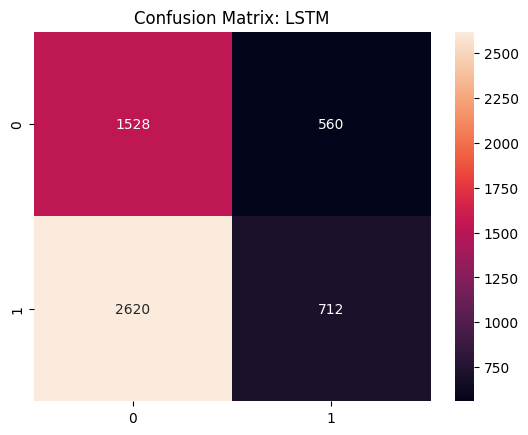

___
Number of total records: 5420
Number of actionable records: 100
Number of actionable records correctly predicted: 56.0
Accuracy on actionable records: 56.00%
No feature importance or coefficients for LSTM
___
Completed training for LSTM model

__________________________________
Beginning grid search for model: RNN.
Testing model with units=150, learning_rate=0.1, batch_size=64, epochs=50
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Testing model with units=150, learning_rate=0.1, batch_size=64, epochs=50
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Testing model with units=150, learning_rate=0.1, batch_size=64, epochs=50
Validation data is availa

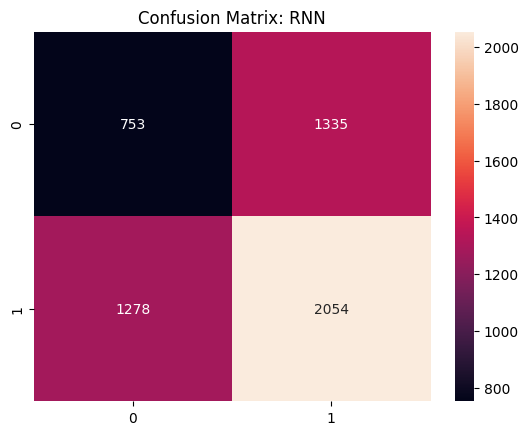

___
Number of total records: 5420
Number of actionable records: 33
Number of actionable records correctly predicted: 20.0
Accuracy on actionable records: 60.61%
No feature importance or coefficients for RNN
___
Completed training for RNN model

__________________________________
Beginning grid search for model: CNN.
Testing model with units=50, learning_rate=0.01, batch_size=128, epochs=10
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Testing model with units=50, learning_rate=0.01, batch_size=128, epochs=10
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Testing model with units=50, learning_rate=0.01, batch_size=128, epochs=10
Validation data is available. X_val shape: (5624, 60, 33), y_val shape: (5624,)
Epo

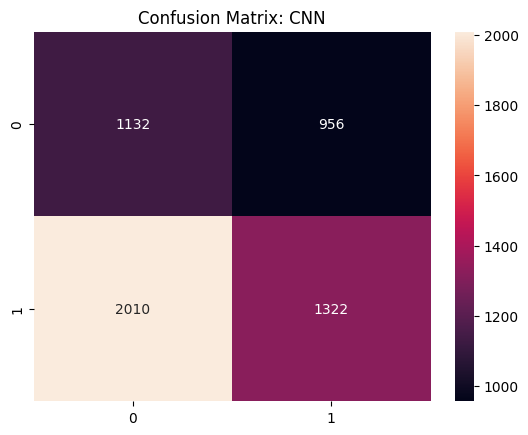

___
Number of total records: 5420
Number of actionable records: 207
Number of actionable records correctly predicted: 123.0
Accuracy on actionable records: 59.42%
No feature importance or coefficients for CNN
___
Completed training for CNN model

__________________________________
Random sets of dates generated to split training & validation.
Data split into training & validation. Train data shape: (21117, 132), Validation data shape: (5420, 132)
Data smoted.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
___
K-Nearest Neighbors - F1 Score: 0.5135911899473564
___
Confusion Matrix:
 [[1061 1027]
 [1645 1687]]
___
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.51      0.44      2088
           1       0.62      0.51      0.56      3332

    accuracy                           0.51      5420
   macro avg       0.51      0.51      0.50      5420
weighted avg       0.53      0.51      0.51      5420

___


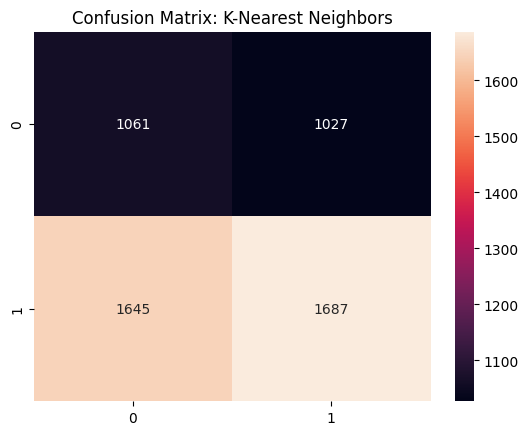

___
Number of total records: 5420
Number of actionable records: 331
Number of actionable records correctly predicted: 218
Accuracy on actionable records: 65.86%
No feature importance or coefficients for K-Nearest Neighbors
___
Completed training for K-Nearest Neighbors model

__________________________________
Fitting 3 folds for each of 20 candidates, totalling 60 fits
___
XGBoost - F1 Score: 0.4576844446007175
___
Confusion Matrix:
 [[ 958 1130]
 [1848 1484]]
___
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.46      0.39      2088
           1       0.57      0.45      0.50      3332

    accuracy                           0.45      5420
   macro avg       0.45      0.45      0.45      5420
weighted avg       0.48      0.45      0.46      5420

___


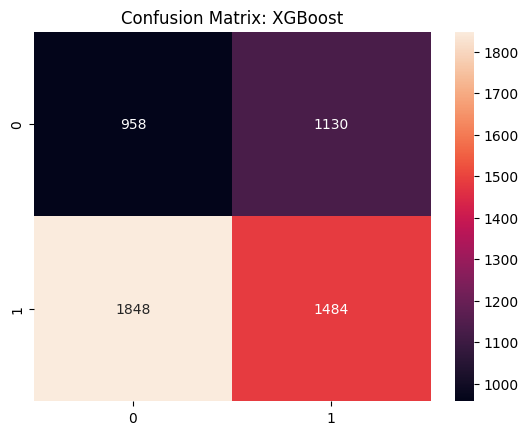

___
Number of total records: 5420
Number of actionable records: 28
Number of actionable records correctly predicted: 20
Accuracy on actionable records: 71.43%
Feature importances for XGBoost:
                       feature  importance
11         EMA_15_120_PCT_DIFF    0.099590
5                         VWAP    0.096343
27                 DAY_OF_WEEK    0.092993
30  WEEKLY_MOVEMENT_SINCE_OPEN    0.086291
29   DAILY_MOVEMENT_SINCE_OPEN    0.081247
2                          LOW    0.074890
1                         HIGH    0.073491
0                        CLOSE    0.065391
9                      EMA_120    0.063694
7                      SMA_120    0.060332
10         SMA_15_120_PCT_DIFF    0.057096
22         ICHIMOKU_TENKAN_SEN    0.046487
6                       SMA_15    0.043158
12                   MACD_DIFF    0.028845
21                         ATR    0.016025
3                         OPEN    0.007920
14                         RSI    0.006205
23                         RVI    

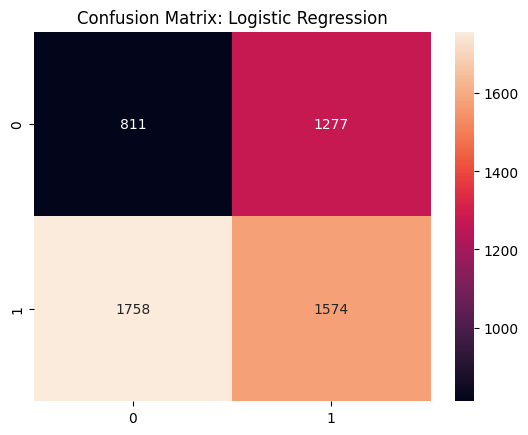

___
Number of total records: 5420
Number of actionable records: 38
Number of actionable records correctly predicted: 18
Accuracy on actionable records: 47.37%
Coefficients for Logistic Regression:
                       feature   coefficient
10         SMA_15_120_PCT_DIFF  1.284178e+00
32     PCT_MOVEMENT_60_PERIODS  5.275495e-01
25                      AO_IND  4.136779e-01
27                 DAY_OF_WEEK  2.458133e-01
5                         VWAP  2.359846e-01
29   DAILY_MOVEMENT_SINCE_OPEN  1.301880e-01
28                 HOUR_OF_DAY  1.101003e-02
15                STOCHASTIC_K  3.519598e-03
13                         ADX  1.992202e-03
23                         RVI  1.087317e-03
17                         CCI  5.674330e-04
4                       VOLUME  7.389761e-08
24                 FORCE_INDEX -1.875948e-05
14                         RSI -3.068272e-04
18                  WILLIAMS_R -3.392741e-04
16                STOCHASTIC_D -6.208469e-04
30  WEEKLY_MOVEMENT_SINCE_OPEN -3.2958

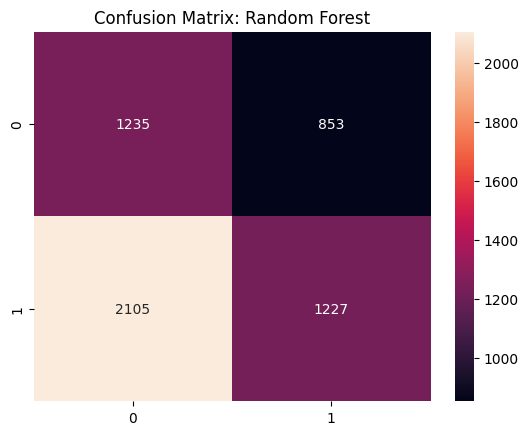

___
Number of total records: 5420
Number of actionable records: 48
Number of actionable records correctly predicted: 36
Accuracy on actionable records: 75.00%
Feature importances for Random Forest:
                       feature  importance
30  WEEKLY_MOVEMENT_SINCE_OPEN    0.104382
29   DAILY_MOVEMENT_SINCE_OPEN    0.097688
5                         VWAP    0.097474
27                 DAY_OF_WEEK    0.066740
9                      EMA_120    0.063656
0                        CLOSE    0.060544
7                      SMA_120    0.060466
1                         HIGH    0.052981
2                          LOW    0.051554
22         ICHIMOKU_TENKAN_SEN    0.044954
6                       SMA_15    0.039491
8                       EMA_15    0.038101
3                         OPEN    0.035425
10         SMA_15_120_PCT_DIFF    0.032710
11         EMA_15_120_PCT_DIFF    0.030475
21                         ATR    0.027195
28                 HOUR_OF_DAY    0.016885
32     PCT_MOVEMENT_60_PERIO

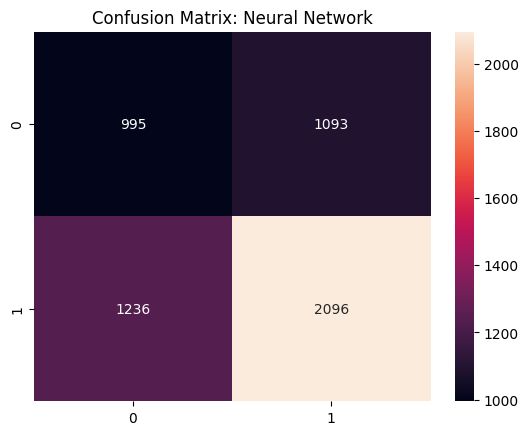

___
Number of total records: 5420
Number of actionable records: 80
Number of actionable records correctly predicted: 46
Accuracy on actionable records: 57.50%
No feature importance or coefficients for Neural Network
___
Completed training for Neural Network model

__________________________________
Fitting 3 folds for each of 20 candidates, totalling 60 fits
___
Gradient Boosting - F1 Score: 0.5025994429997772
___
Confusion Matrix:
 [[1292  796]
 [1913 1419]]
___
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.62      0.49      2088
           1       0.64      0.43      0.51      3332

    accuracy                           0.50      5420
   macro avg       0.52      0.52      0.50      5420
weighted avg       0.55      0.50      0.50      5420

___


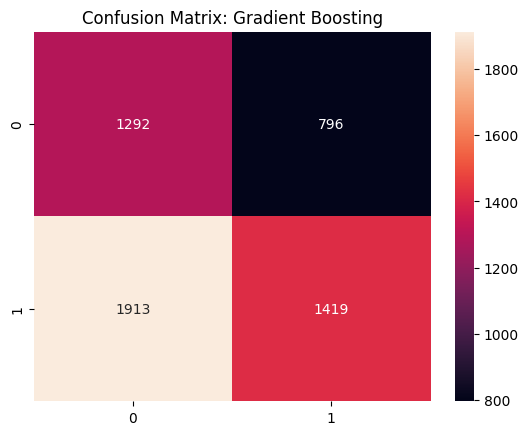

___
Number of total records: 5420
Number of actionable records: 45
Number of actionable records correctly predicted: 36
Accuracy on actionable records: 80.00%
Feature importances for Gradient Boosting:
                       feature    importance
30  WEEKLY_MOVEMENT_SINCE_OPEN  2.294086e-01
29   DAILY_MOVEMENT_SINCE_OPEN  1.635843e-01
5                         VWAP  1.357158e-01
27                 DAY_OF_WEEK  1.109518e-01
0                        CLOSE  7.842398e-02
9                      EMA_120  6.457901e-02
21                         ATR  4.305795e-02
11         EMA_15_120_PCT_DIFF  3.617407e-02
7                      SMA_120  3.552729e-02
10         SMA_15_120_PCT_DIFF  2.731578e-02
1                         HIGH  2.403361e-02
2                          LOW  9.189052e-03
28                 HOUR_OF_DAY  8.906538e-03
22         ICHIMOKU_TENKAN_SEN  8.637226e-03
8                       EMA_15  5.278828e-03
32     PCT_MOVEMENT_60_PERIODS  3.771780e-03
25                      AO_IND  3

d:\Scripts\alpaca\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


___
Support Vector Machine - F1 Score: 0.45083664808495216
___
Confusion Matrix:
 [[ 794 1294]
 [1719 1613]]
___
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.38      0.35      2088
           1       0.55      0.48      0.52      3332

    accuracy                           0.44      5420
   macro avg       0.44      0.43      0.43      5420
weighted avg       0.46      0.44      0.45      5420

___


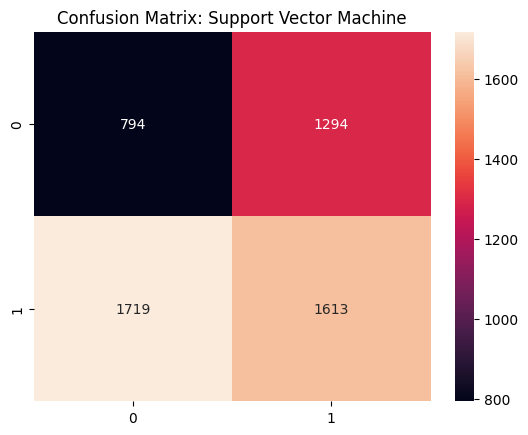

___
Number of total records: 5420
Number of actionable records: 44
Number of actionable records correctly predicted: 18
Accuracy on actionable records: 40.91%
Coefficients for Support Vector Machine:
                       feature  coefficient
0                        CLOSE     6.562472
7                      SMA_120     4.948450
5                         VWAP     3.805836
1                         HIGH     3.091762
2                          LOW     3.089757
3                         OPEN     2.582098
9                      EMA_120     2.283786
29   DAILY_MOVEMENT_SINCE_OPEN     0.775000
10         SMA_15_120_PCT_DIFF     0.720087
27                 DAY_OF_WEEK     0.580451
22         ICHIMOKU_TENKAN_SEN     0.403769
25                      AO_IND     0.209630
32     PCT_MOVEMENT_60_PERIODS     0.196721
23                         RVI     0.115851
13                         ADX     0.109908
16                STOCHASTIC_D     0.079546
15                STOCHASTIC_K     0.024203
18      

In [47]:
# Instantiate and use the trading bot
atb = AlpacaTradingBot()

"""
We will run our predictive models using the following parameters (note that classification models don't care about the sequence_window):

Parameters:
- models: A list of model names to be used for prediction.
- table_name: The name of the table used for classification modeling.
- features: A list of feature names to be used for prediction.
- symbols: A list of symbols for which the models will be run.
- target_threshold: The threshold value for the target variable.
- sequence_window: The window size for the sequential models.
- n_iter: The number of iterations for model training.
- cv: The number of cross-validation folds.
- start_date: Optional parameter to train on smaller dataset.. really just have this here to test out code before running on a big timeframe
"""

table_name = 'MODEL_TRAINING_DATA'
target_threshold = .003
sequence_window = 60
n_iter=20
cv=3
start_date = '2024-02-01'

symbols = [
    'MSFT'
    ]
models = [
    'LSTM', 'RNN', 'CNN',
    'K-Nearest Neighbors', 'XGBoost', 'Logistic Regression', 
    'Random Forest', 'Neural Network', 'Gradient Boosting', 'Support Vector Machine'
    ]
features = [
    'CLOSE', 'HIGH', 'LOW', 'OPEN', 'VOLUME', 'VWAP', 'SMA_15', 'SMA_120', 
    'EMA_15', 'EMA_120', 'SMA_15_120_PCT_DIFF', 'EMA_15_120_PCT_DIFF', 
    'MACD_DIFF', 'ADX', 'RSI', 'STOCHASTIC_K', 'STOCHASTIC_D', 'CCI', 
    'WILLIAMS_R','BOLLINGER_WIDTH_PERCENT', 'BOLLINGER_POSITION', 'ATR', 
    'ICHIMOKU_TENKAN_SEN', 'RVI', 'FORCE_INDEX', 'AO_IND', 'HIGH_LOW_RANGE', 
    'DAY_OF_WEEK', 'HOUR_OF_DAY', 'DAILY_MOVEMENT_SINCE_OPEN',
    'WEEKLY_MOVEMENT_SINCE_OPEN', 'PCT_MOVEMENT_20_PERIODS', 'PCT_MOVEMENT_60_PERIODS' 
    ]

    # Unused features
    # 'TRADE_COUNT', 'SMA_30', 'EMA_30', 'MACD', 'MACD_SIGNAL', 'BOLLINGER_HBAND', 'OBV', 'ICHIMOKU_SENKOU_SPAN_A', 'ICHIMOKU_SENKOU_SPAN_B', 
    # 'BOLLINGER_LBAND', 'BOLLINGER_MBAND', 'RSI_LAG1', 'MACD_DIFF_LAG1', 'CCI_LAG1', 'ADX_LAG1', 
    # 'CLOSE_LAG1', 'VOLUME_LAG1', 'VWAP_LAG1', 'ATR_LAG1', 'RSI_LAG2', 
    # 'MACD_DIFF_LAG2', 'CCI_LAG2', 'ADX_LAG2', 'CLOSE_LAG2', 'VOLUME_LAG2', 
    # 'VWAP_LAG2', 'ATR_LAG2', 'RSI_LAG3', 'MACD_DIFF_LAG3', 'CCI_LAG3', 
    # 'ADX_LAG3', 'CLOSE_LAG3', 'VOLUME_LAG3', 'VWAP_LAG3', 'ATR_LAG3', 
    # 'RSI_LAG4', 'MACD_DIFF_LAG4', 'CCI_LAG4', 'ADX_LAG4', 'CLOSE_LAG4', 
    # 'VOLUME_LAG4', 'VWAP_LAG4', 'ATR_LAG4', 'RSI_LAG5', 'MACD_DIFF_LAG5', 
    # 'CCI_LAG5', 'ADX_LAG5', 'CLOSE_LAG5', 'VOLUME_LAG5', 'VWAP_LAG5', 
    # 'ATR_LAG5', 'RSI_LAG10', 'MACD_DIFF_LAG10', 'CCI_LAG10', 'ADX_LAG10', 
    # 'CLOSE_LAG10', 'VOLUME_LAG10', 'VWAP_LAG10', 'ATR_LAG10', 'RSI_LAG20', 
    # 'MACD_DIFF_LAG20', 'CCI_LAG20', 'ADX_LAG20', 'CLOSE_LAG20', 'VOLUME_LAG20', 
    # 'VWAP_LAG20', 'ATR_LAG20', 'RSI_LAG30', 'MACD_DIFF_LAG30', 'CCI_LAG30', 
    # 'ADX_LAG30', 'CLOSE_LAG30', 'VOLUME_LAG30', 'VWAP_LAG30', 'ATR_LAG30', 
    # 'RSI_SQUARED', 'CCI_SQUARED', 'MACD_SQUARED', 'ADX_SQUARED', 
    # 'MACD_DIFF_SQUARED', 'STOCHASTIC_D_SQUARED', 'STOCHASTIC_K_SQUARED', 
    # 'WILLIAMS_R_SQUARED', 'OBV_SQUARED', 'BOLLINGER_WIDTH_PERCENT_SQUARED', 
    # 'SMA_30_RSI', 'MACD_STOCHASTIC_K', 'EMA_30_ATR', 'RSI_MACD_DIFF_INTERACTION', 
    # 'SMA_30_ADX_INTERACTION', 'BOLLINGER_POSITION_ATR_INTERACTION', 'TIME_OF_DAY', 

# Run sequential models
for symbol in symbols:
    print(f"Processing symbol: {symbol}")
    atb.modeling_build(models, table_name, features, symbol, target_threshold, sequence_window, n_iter, cv, start_date)
    print(f"Completed modeling for symbol: {symbol}\n")


### Apply Predictions

In [ ]:
"""

Query current day's data, insert to stage, add indicators & add model predictions based on already created models.

"""
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Just query current day's data
# start_date = datetime.now().strftime("%Y-%m-%d")
# end_date = datetime.now().strftime("%Y-%m-%d")

# Step 1: Download ticks and add to stage table
# data = {}
# for stock in stocks:
    # Download historical data
    # stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    # data[stock] = stock_data

# Store all downloaded data in the staging table
# for stock, stock_data in data.items():
#     atb.db_append_no_duplicates('STG_SYMBOL_DATA', stock_data)
#     print(f"Stage table updated with data for {stock}")

# Step 2: Transfer data from the staging table to the modeling staging table
for stock in stocks:
    atb.classification_modeling_apply('STG_SYMBOL_DATA', stock, "CLASSIFICATION_MODEL_PREDICTIONS")
    print(f"Model predictions for {stock} stored in CLASSIFICATION_MODEL_PREDICTIONS.")